In [16]:
import traitlets
import threading
import numpy as np


class Camera(traitlets.HasTraits):

    value = traitlets.Any()
    width = traitlets.Integer(default_value=640)
    height = traitlets.Integer(default_value=480)
    format = traitlets.Unicode(default_value='bgr8')
    running = traitlets.Bool(default_value=False)
    
    def __init__(self, *args, **kwargs):
        super(Camera, self).__init__(*args, **kwargs)
        if self.format == 'bgr8':
            self.value = np.empty((self.height, self.width, 3), dtype=np.uint8)
        self._running = False
            
    def _read(self):
        """Blocking call to read frame from camera"""
        raise NotImplementedError
        
    def read(self):
        if self._running:
            raise RuntimeError('Cannot read directly while camera is running')
        self.value = self._read()
        return self.value
    
    def _capture_frames(self):
        while True:
            if not self._running:
                break
            self.value = self._read()
            
    @traitlets.observe('running')
    def _on_running(self, change):
        if change['new'] and not change['old']:
            # transition from not running -> running
            self._running = True
            self.thread = threading.Thread(target=self._capture_frames)
            self.thread.start()
        elif change['old'] and not change['new']:
            # transition from running -> not running
            self._running = False
            self.thread.join()

In [17]:
import atexit
import cv2



class CSICamera(Camera):
    
    capture_device = traitlets.Integer(default_value=0)
    capture_fps = traitlets.Integer(default_value=30)
    capture_width = traitlets.Integer(default_value=1920)
    capture_height = traitlets.Integer(default_value=1080)
    
    def __init__(self, *args, **kwargs):
        super(CSICamera, self).__init__(*args, **kwargs)
        print("yolo")
        print(self._gst_str())
        try:
            self.cap = cv2.VideoCapture(self._gst_str(), cv2.CAP_GSTREAMER)

            re, image = self.cap.read()

            if not re:
                raise RuntimeError('Could not read image from camera.')
            print("looks to be succesful")
        except:
            raise RuntimeError(
                'Could not initialize camera.  Please see error trace.')

        atexit.register(self.cap.release)
        
                
    def _gst_str(self):
        return 'nvarguscamerasrc sensor-id=%d ! video/x-raw(memory:NVMM), width=%d, height=%d, format=(string)NV12, framerate=(fraction)%d/1 ! nvvidconv ! video/x-raw, width=(int)%d, height=(int)%d, format=(string)BGRx ! videoconvert ! appsink' % (
                self.capture_device, self.capture_width, self.capture_height, self.capture_fps, self.width, self.height)
    
    def _read(self):
        re, image = self.cap.read()
        if re:
            return image
        else:
            raise RuntimeError('Could not read image from camera')

In [18]:
# note that frame rate seems to have to be 30 for this to work at a resolution of 640 x 480
camera = CSICamera()

yolo
nvarguscamerasrc sensor-id=0 ! video/x-raw(memory:NVMM), width=1920, height=1080, format=(string)NV12, framerate=(fraction)30/1 ! nvvidconv ! video/x-raw, width=(int)640, height=(int)480, format=(string)BGRx ! videoconvert ! appsink


RuntimeError: Could not initialize camera.  Please see error trace.

In [19]:
image = camera.read()
print(image.shape)
image = cv2.resize(image, (224, 224))
print(image.shape)

(480, 640, 3)
(224, 224, 3)


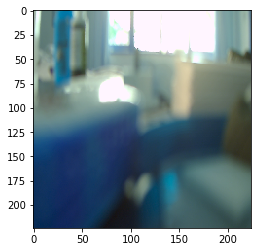

In [20]:
%matplotlib inline

from matplotlib import pyplot as plt

plt.imshow(image)
plt.show()

In [21]:
import ipywidgets
from IPython.display import display

def bgr8_to_jpeg(value, quality=75):
    return bytes(cv2.imencode('.jpg', value)[1])

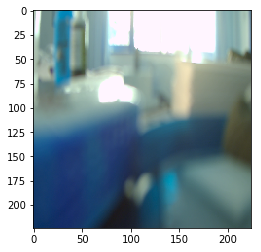

In [15]:
image_widget = ipywidgets.Image(format='jpeg')
image_widget.value = bgr8_to_jpeg(image)

plt.imshow(image)
plt.show()


In [28]:
path = './Desktop/CameraCode/test.jpg'
image = cv2.imread(path)
print(image)
plt.imshow(float(image))
plt.show()


None


TypeError: float() argument must be a string or a number, not 'NoneType'

nvarguscamerasrc ! video/x-raw(memory:NVMM), width=(int)1280, height=(int)720, format=(string)NV12, framerate=(fraction)30/1 ! nvvidconv flip-method=0 ! video/x-raw, width=(int)1280, height=(int)720, format=(string)BGRx ! videoconvert ! video/x-raw, format=(string)BGR ! appsink
cap read True
img [[[ 0 43 59]
  [ 0 44 62]
  [ 0 43 66]
  ..., 
  [ 0 25 44]
  [ 0 28 55]
  [ 0 29 55]]

 [[ 0 41 62]
  [ 0 42 65]
  [ 0 43 63]
  ..., 
  [ 0 25 48]
  [ 2 33 49]
  [ 0 31 52]]

 [[ 0 40 64]
  [ 0 44 62]
  [ 0 43 63]
  ..., 
  [ 0 29 50]
  [ 7 27 52]
  [ 0 33 54]]

 ..., 
 [[ 4  2  4]
  [ 0  6 31]
  [ 4 10 10]
  ..., 
  [ 0 17 42]
  [ 7 24 37]
  [ 0 18 40]]

 [[ 0 10 32]
  [ 0  0 26]
  [ 0  5 31]
  ..., 
  [ 0 22 32]
  [ 0 15 43]
  [ 0 10 44]]

 [[ 0  2 29]
  [ 0 11  1]
  [ 0 10 27]
  ..., 
  [ 0 22 44]
  [ 0 19 47]
  [ 5 19 46]]]
exiting while loop


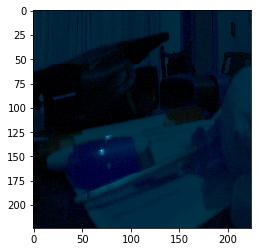

In [2]:
import cv2
from matplotlib import pyplot as plt

# gstreamer_pipeline returns a GStreamer pipeline for capturing from the CSI camera
# Defaults to 1280x720 @ 60fps
# Flip the image by setting the flip_method (most common values: 0 and 2)
# display_width and display_height determine the size of the window on the screen


def gstreamer_pipeline(
    capture_width=1280,
    capture_height=720,
    display_width=1280,
    display_height=720,
    framerate=30,
    flip_method=0,
):
    return (
        "nvarguscamerasrc ! "
        "video/x-raw(memory:NVMM), "
        "width=(int)%d, height=(int)%d, "
        "format=(string)NV12, framerate=(fraction)%d/1 ! "
        "nvvidconv flip-method=%d ! "
        "video/x-raw, width=(int)%d, height=(int)%d, format=(string)BGRx ! "
        "videoconvert ! "
        "video/x-raw, format=(string)BGR ! appsink"
        % (
            capture_width,
            capture_height,
            framerate,
            flip_method,
            display_width,
            display_height,
        )
    )

gst_ = 'nvarguscamerasrc ! video/x-raw(memory:NVMM), width=%d, height=%d, format=(string)NV12, framerate=(fraction)%d/1 ! nvvidconv ! video/x-raw, width=(int)%d, height=(int)%d, format=(string)BGRx ! videoconvert ! appsink' % (1920, 1080, 20, 224,224)

def show_camera():
    # To flip the image, modify the flip_method parameter (0 and 2 are the most common)
    print(gstreamer_pipeline(flip_method=0))
    cap = cv2.VideoCapture(gst_, cv2.CAP_GSTREAMER)
    if cap.isOpened():
        re, img = cap.read()
        print("cap read", re)
        print("img", img)
        plt.imshow(img)
        cv2.waitKey(1000)
        """while True:
            print("cap is opened")
            re, img = cap.read()
            print("cap read", re)
            plt.imshow(img)
            cv2.waitKey(10)"""
        
        print("exiting while loop")


show_camera()  